In [1]:
pip install -q -r requirements.txt

Note: you may need to restart the kernel to use updated packages.


In [2]:
import pandas as pd
import numpy as np

from statsforecast import StatsForecast
import time
from statsforecast.models import (
    HistoricAverage,
    DynamicOptimizedTheta as DOT,
    SeasonalNaive,
    AutoARIMA,
    AutoETS,
    Naive
)
from utilsforecast.losses import *
from neuralforecast import NeuralForecast
from neuralforecast.models import NBEATS
from utilsforecast.evaluation import evaluate

from functools import partial
import seaborn as sns
import matplotlib.pyplot as plt

from transformers import AutoModelForCausalLM
from chronos import BaseChronosPipeline
import scipy.stats as stats 

import lightgbm as lgb
from sklearn.linear_model import LinearRegression

from importlib import reload
import utils
reload(utils)
from utils import prepare_data, TimeMoEPredictor, chronosPredictor, LLM, wape

from mlforecast import MLForecast
from mlforecast.lag_transforms import ExpandingMean, RollingMean
from mlforecast.target_transforms import Differences



/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-12-07 16:31:31,701	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.
2024-12-07 16:31:31,744	INFO util.py:154 -- Missing packages: ['ipywidgets']. Run `pip install -U ipywidgets`, then restart the notebook server for rich notebook output.


## Prepare data

In [3]:
train, test = prepare_data(sample_size=1000,series_cutoff=48)

/home/jan/m4_tests/utils.py:22: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  .assign(StartingDate = lambda x : pd.to_datetime(x["StartingDate"]))
/home/jan/m4_tests/utils.py:39: FutureWarning: The provided callable <built-in function max> is currently using SeriesGroupBy.max. In a future version of pandas, the provided callable will be used directly. To keep current behavior pass the string "max" instead.
  df["max"] = df.groupby("unique_id")["row"].transform(max)


In [4]:
# Create a list of models and instantiation parameters
season_length = 12

models_classes_stats = [
    DOT(season_length=season_length),
    AutoARIMA(),
    AutoETS(),
    Naive()
]

model_classes_neural = [
    NBEATS(h=3, input_size=10,
               stack_types = ['identity', 'trend', 'seasonality']
            )
]

model_classes_ml = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    LinearRegression(),
]

model_classes_custom = [TimeMoEPredictor(input_length=24,device="cpu"),chronosPredictor(input_length=24,device="cuda")]


Seed set to 1
/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
model_wrappers = {}
model_names = []

neural = True
stats = True
ML = True
custom = True

if neural:
    for model in model_classes_neural:
        model_name = str(model)
        model_names.append(model_name)
        model_wrappers[model_name]=(
            NeuralForecast( 
                models=[model],
                freq="ME"
            )
        )    

if stats:
    for model in models_classes_stats:
        model_name = str(model)
        model_names.append(model_name)
        model_wrappers[model_name]=(
            StatsForecast( 
                models=[model],
                freq="ME", 
                fallback_model = SeasonalNaive(season_length=12),
                n_jobs=-1,
            )
        )    

if ML:
    for model in model_classes_ml:
        model_name = str(model).split("(")[0]
        model_names.append(model_name)
        model_wrappers[model_name]=(
            MLForecast(
                models=model,
                freq='ME',
                lags=[1,2,3,4,5,6,7,8,9,10],
                lag_transforms={
                    1: [ExpandingMean(),RollingMean(window_size=12),RollingMean(window_size=3),RollingMean(window_size=6),RollingMean(window_size=12)],        
                },
                date_features=['dayofweek'],
                target_transforms=[Differences([1])],
            )
        )

if custom:
    for model in model_classes_custom:
        model_name = str(type(model).__name__)
        model_names.append(model_name)
        model_wrappers[model_name] = model

In [6]:
model_wrappers

{'NBEATS': <neuralforecast.core.NeuralForecast at 0x7f9732492db0>,
 'DynamicOptimizedTheta': StatsForecast(models=[DynamicOptimizedTheta]),
 'AutoARIMA': StatsForecast(models=[AutoARIMA]),
 'AutoETS': StatsForecast(models=[AutoETS]),
 'Naive': StatsForecast(models=[Naive]),
 'LGBMRegressor': MLForecast(models=[LGBMRegressor], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size12', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6'], date_features=['dayofweek'], num_threads=1),
 'LinearRegression': MLForecast(models=[LinearRegression], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size12', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6'], date_features=['dayofweek'], num_threads=1),
 'TimeMoEPredictor': <utils.TimeMoEPredictor at 0x7f9733f14c5

In [7]:
fit_times = []

for model_name, model in model_wrappers.items():
    if not isinstance(model, LLM):
        start = time.time()
        model.fit(df=train)
        fit_times.append(time.time()-start)
    

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3060') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name         | Type          | Params | Mode 
-------------------------------------------------------
0 | loss         | MAE           | 0      | train
1 | padder_train | ConstantPad1d | 0      | train
2 | scaler       | TemporalNorm  | 0      | train
3 | blocks       | ModuleList    | 2.4 M  | train
-------------------------------------------------------
2.4 M     Trainable params
91        Non-trainable params
2.4 M     Total params
9.579     Total estimated model params size (MB)
31        Modules in train mode
0         Modules in eval mode


Epoch 32:  26%|██▌       | 8/31 [00:00<00:00, 101.36it/s, v_num=40, train_loss_step=260.0, train_loss_epoch=363.0] 

`Trainer.fit` stopped: `max_steps=1000` reached.


Epoch 32:  26%|██▌       | 8/31 [00:00<00:00, 100.50it/s, v_num=40, train_loss_step=260.0, train_loss_epoch=363.0]


In [8]:
forecast_dict = {}
forecast_times = []

def add_model(forecasts,model_name):
    forecast_dict[model_name] = forecasts
    
for model_name, model in model_wrappers.items():
    print(model)
    
    start = time.time()

    if isinstance(model, NeuralForecast):
        add_model(model.predict().reset_index(),model_name)
    elif (isinstance(model,StatsForecast)) or (isinstance(model,MLForecast)):
        add_model(model.predict(h=3),model_name)
    else:
        add_model(model.predict(train,test,h=3),model_name)
        fit_times.append(0)

    forecast_times.append(time.time()-start)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Predicting DataLoader 0: 100%|██████████| 31/31 [00:00<00:00, 657.62it/s]
StatsForecast(models=[DynamicOptimizedTheta])


/home/jan/m4_tests/.venv/lib64/python3.12/site-packages/neuralforecast/core.py:214: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


StatsForecast(models=[AutoARIMA])
StatsForecast(models=[AutoETS])
StatsForecast(models=[Naive])
MLForecast(models=[LGBMRegressor], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size12', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6'], date_features=['dayofweek'], num_threads=1)
MLForecast(models=[LinearRegression], freq=ME, lag_features=['lag1', 'lag2', 'lag3', 'lag4', 'lag5', 'lag6', 'lag7', 'lag8', 'lag9', 'lag10', 'expanding_mean_lag1', 'rolling_mean_lag1_window_size12', 'rolling_mean_lag1_window_size3', 'rolling_mean_lag1_window_size6'], date_features=['dayofweek'], num_threads=1)
969
2907


In [9]:
forecast_times

[0.1438887119293213,
 4.788097620010376,
 0.5590846538543701,
 0.46139097213745117,
 0.3595006465911865,
 0.00745391845703125,
 0.005228996276855469,
 6.624903678894043,
 0.22507762908935547]

In [10]:
train

,unique_id,y,ds
0,M10000,2740.0,2013-05-31
1,M10000,3000.0,2013-06-30
2,M10000,3040.0,2013-07-31
3,M10000,2920.0,2013-08-31
4,M10000,2870.0,2013-09-30
...,...,...,...
46504,M9964,700.0,2016-08-31
46505,M9964,630.0,2016-09-30
46506,M9964,630.0,2016-10-31
46507,M9964,610.0,2016-11-30


In [11]:
weights = (
    train
        .groupby("unique_id",)["y"]
        .sum()
        .rename("weights")
)

weights = weights/weights.sum()

In [12]:
metrics = [
    mape,
    wape,
    rmse,
    partial(mase, seasonality=12),
    partial(rmsse, seasonality=12),
]

In [13]:
test = test.reset_index()

for name,forecast in forecast_dict.items():
    test = test.merge(forecast, on = ["ds","unique_id"],how="inner")

In [14]:
eval = evaluate(test, metrics=metrics, train_df=train)

In [15]:
eval[eval["metric"]=='wape']

,unique_id,metric,index,NBEATS,DynamicOptimizedTheta,AutoARIMA,AutoETS,Naive,LGBMRegressor,LinearRegression,TimeMoEPredictor,chronosPredictor
969,M10000,wape,55.811594,0.201669,0.075334,0.132681,0.075875,0.075881,0.080310,0.093896,0.209032,0.175989
970,M10127,wape,10.829787,0.007739,0.006670,0.005790,0.004706,0.010909,0.005203,0.017610,0.020023,0.013426
971,M1013,wape,15.760563,0.219523,0.421654,0.430123,0.312701,0.184932,0.308239,0.301867,0.220727,0.119386
972,M10176,wape,16.712456,0.050282,0.008163,0.068563,0.066508,0.066508,0.061165,0.051395,0.062621,0.064004
973,M10280,wape,30.602241,0.001629,0.002676,0.028204,0.006735,0.002577,0.010294,0.019227,0.005522,0.011573
...,...,...,...,...,...,...,...,...,...,...,...,...
1933,M9825,wape,0.938829,0.166334,0.254173,0.214118,0.274197,0.133333,0.145346,0.147271,0.065976,0.090920
1934,M983,wape,0.872608,0.026654,0.029149,0.013054,0.036268,0.036257,0.040281,0.061412,0.035509,0.016283
1935,M9922,wape,0.982333,0.056405,0.180159,0.114212,0.180002,0.180000,0.169213,0.066773,0.108199,0.171973
1936,M9942,wape,0.967716,0.130962,0.128312,0.127907,0.127911,0.127907,0.132407,0.129971,0.142813,0.119430


In [16]:
eval.drop(columns=["index"]).set_index(["unique_id","metric" ]).stack().reset_index().set_index(["unique_id",'metric', 'level_2']).unstack(level=1).corr()

0                                        
metric        mape      mase      rmse     rmsse      wape
  metric                                                  
0 mape    1.000000  0.165819  0.406906  0.155654  0.375588
  mase    0.165819  1.000000  0.362112  0.966667  0.351154
  rmse    0.406906  0.362112  1.000000  0.391985  0.758762
  rmsse   0.155654  0.966667  0.391985  1.000000  0.361772
  wape    0.375588  0.351154  0.758762  0.361772  1.000000

In [17]:
eval.drop(columns=["index"]).set_index(["unique_id","metric" ]).stack().reset_index().set_index(["unique_id",'metric', 'level_2']).unstack(level=1).describe()

0                                                     
metric         mape         mase          rmse        rmsse         wape
count   8721.000000  8721.000000   8721.000000  8721.000000  8721.000000
mean       0.141532     0.820248    504.498395     0.735418     0.109843
std        0.468225     1.108944   1229.538281     0.959793     0.239304
min        0.000000     0.000000      0.000000     0.000000     0.000000
25%        0.014211     0.248657     57.690068     0.236629     0.014217
50%        0.039563     0.528660    162.433576     0.489316     0.040220
75%        0.121776     0.986947    435.530873     0.893192     0.120266
max        9.022224    17.106852  19959.879276    13.808181     6.932441

In [18]:
metrics = eval.drop(columns="index").set_index(["unique_id","metric"]).stack().rename_axis(index={None: 'Model'}).rename("value")

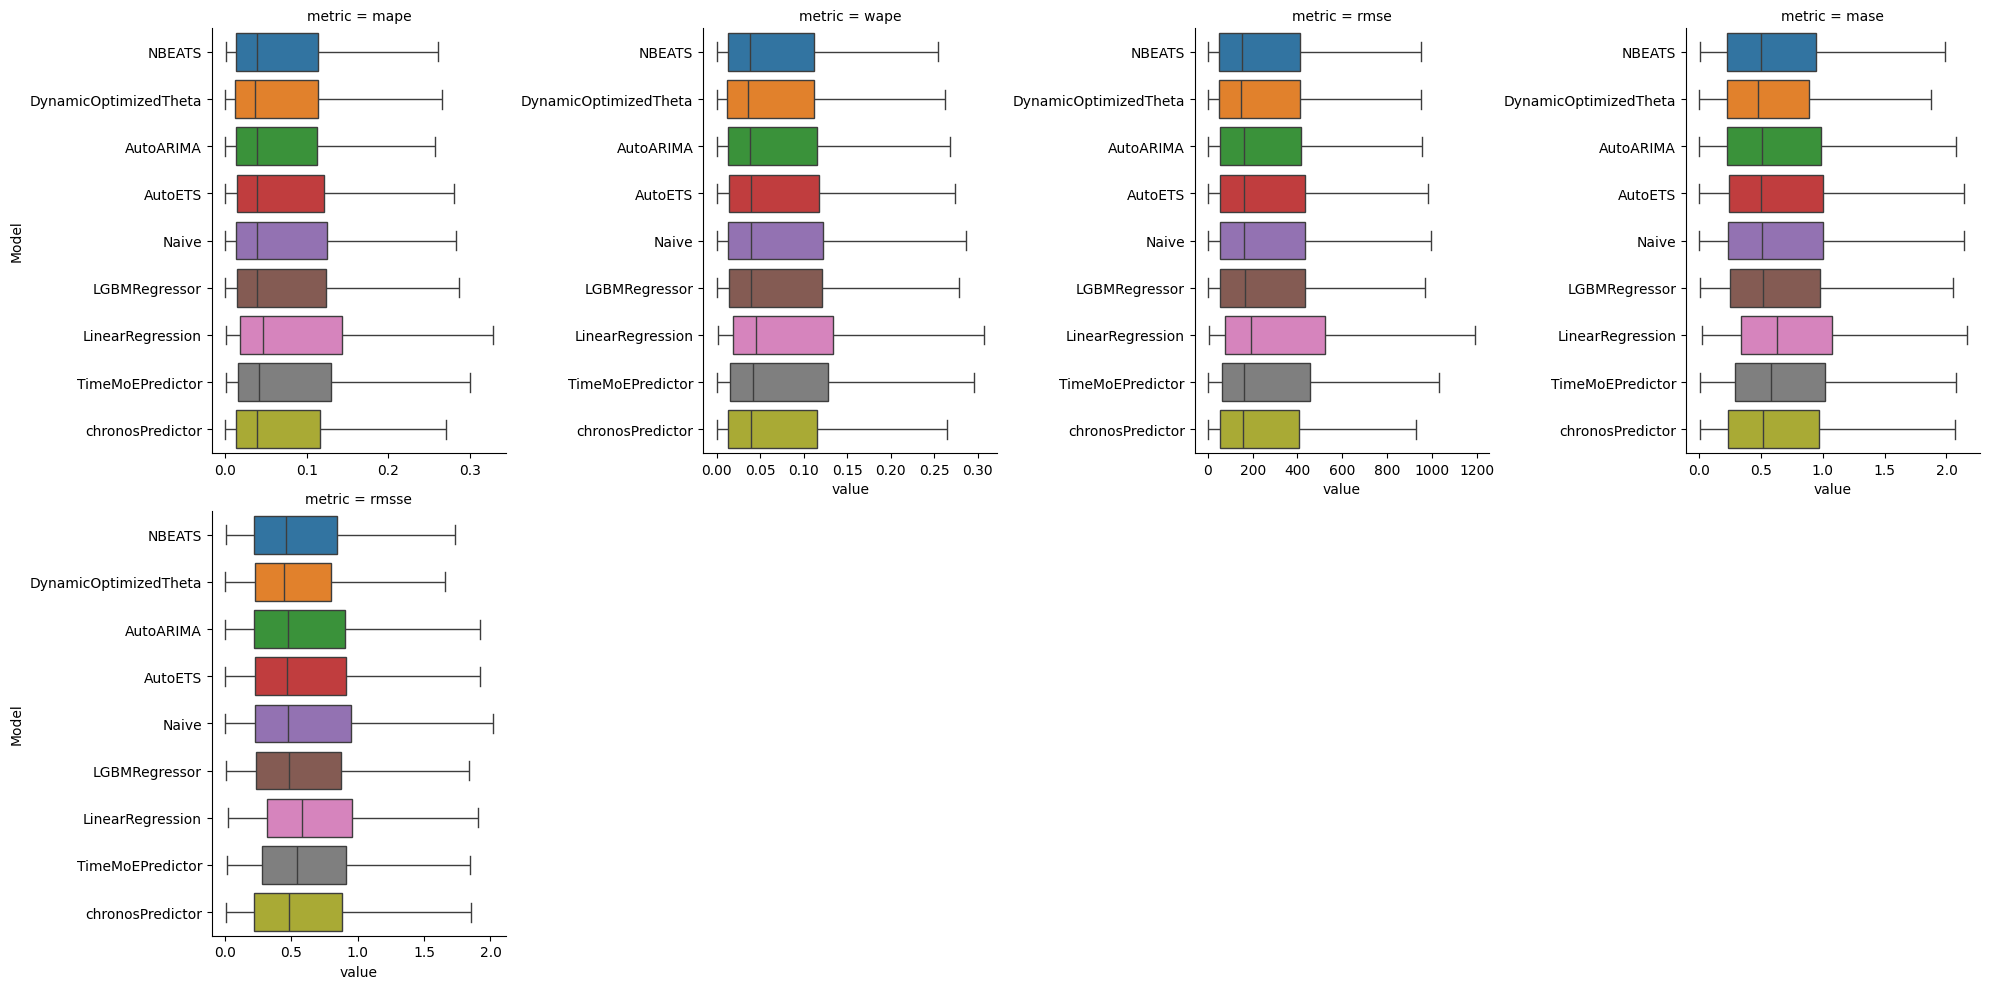

In [19]:
sns.catplot(
    data=metrics.reset_index(), x='value', y='Model',hue="Model",sharey=False,sharex=False,showfliers=False,
    col='metric', kind='box', col_wrap=4
)

In [20]:
times = pd.DataFrame(
    {
        "Model":model_names,
        "fit_time":fit_times,
        "inference_time":forecast_times
    }
).set_index("Model")

In [21]:
metrics.groupby(level=[1,2]).median().unstack()

Model,AutoARIMA,AutoETS,DynamicOptimizedTheta,LGBMRegressor,LinearRegression,NBEATS,Naive,TimeMoEPredictor,chronosPredictor
metric,,,,,,,,,
mape,0.038461,0.039501,0.036549,0.038495,0.046014,0.038817,0.039476,0.041570,0.038973
mase,0.511419,0.500635,0.472625,0.513453,0.628899,0.503271,0.511628,0.582579,0.519466
rmse,159.613074,163.240592,149.430541,166.002812,191.099144,154.379709,159.894270,162.394776,158.606762
rmsse,0.470388,0.463527,0.442191,0.483490,0.576367,0.461039,0.476075,0.545269,0.478948
wape,0.038321,0.039940,0.036588,0.039338,0.045642,0.038741,0.040000,0.041810,0.039676


In [22]:
md = metrics.groupby(level=[1,2]).median().to_frame().join(times).set_index("value",append=True).stack().rename_axis(index={None: 'time'}).rename("time_value").reset_index()

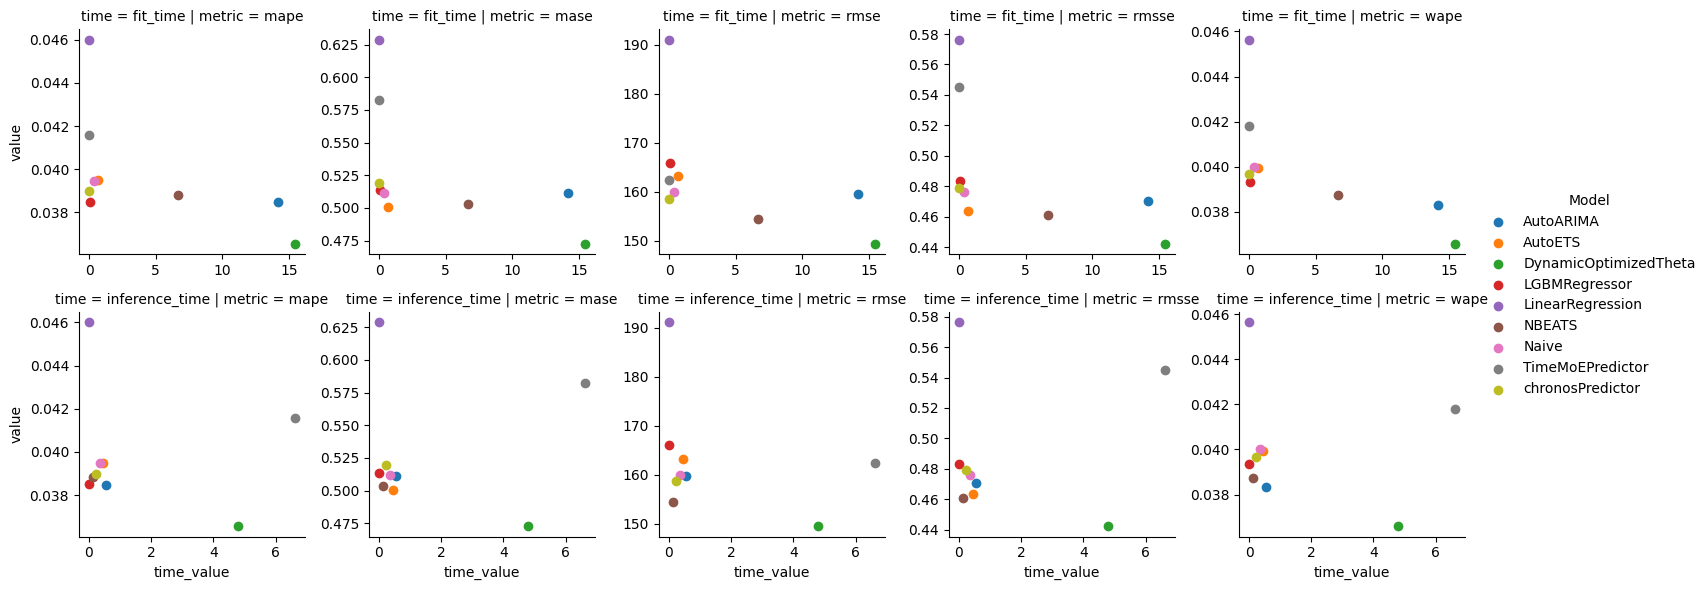

In [23]:
g = sns.FacetGrid(md, row= "time", col="metric", hue = "Model",sharey=False,sharex=False)
g = g.map(plt.scatter, "time_value", "value")
g.add_legend()

In [141]:
(
    metrics
        #[metrics.index.get_level_values(level=1).isin(["rmsse","rmse","mape","wape"])]
        .reset_index().merge(weights, on = "unique_id")
        .assign(metric = lambda x : "w"+x["metric"],
                value = lambda x : x.value*x.weights
                )
        .groupby(["metric","Model"])["value"]
        .sum()
        .sort_values()
        .unstack(level=0)
        .reset_index()
        .sort_values(by="wrmsse")
)

metric,Model,wmape,wmase,wrmse,wrmsse,wwape
2,DynamicOptimizedTheta,0.125699,0.664444,634.823677,0.607902,0.092560
8,chronosPredictor,0.121591,0.750291,650.248989,0.683251,0.098049
7,TimeMoEPredictor,0.119628,0.770943,645.332706,0.700601,0.096628
5,NBEATS,0.113143,0.774813,619.555000,0.703006,0.098258
0,AutoARIMA,0.118539,0.794557,644.390045,0.717502,0.096154
3,LGBMRegressor,0.120646,0.808429,636.656692,0.728759,0.092958
1,AutoETS,0.131126,0.835627,671.277007,0.748742,0.098823
6,Naive,0.137160,0.865451,723.762880,0.776701,0.109259
4,LinearRegression,0.135390,0.882787,698.575723,0.785953,0.102882


In [110]:
df = metrics.unstack(level=1).reset_index().drop(columns=["unique_id"])

In [107]:
from itertools import product
from scipy import stats
import pandas as pd

cols = df.columns.difference(['Model'])

g = df.groupby('Model')[cols]

out = pd.concat({(a, b): pd.DataFrame(stats.ttest_rel(g.get_group(a), g.get_group(b),alternative="less"),
                                      columns=cols, index=['statistic', 'pvalue'])
                 for a, b in product(df['Model'].unique(), repeat=2)
                }, names=['product1', 'product2'])


<Axes: xlabel='None-product2', ylabel='product1-metric'>

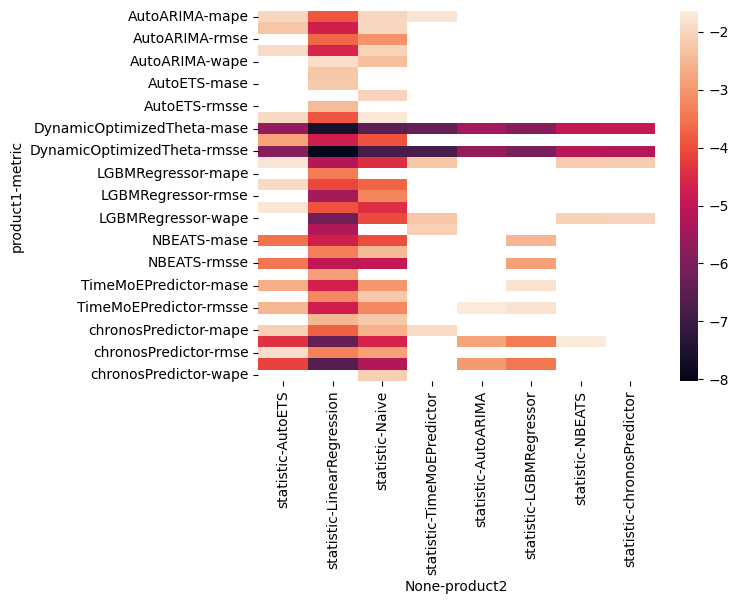

In [114]:
sns.heatmap(out.stack().unstack(level=2).loc[lambda x : x.pvalue <0.05].drop(columns="pvalue").unstack(level=1))